<a href="https://colab.research.google.com/github/AIFFEL-GN-2nd/TotochTeam3/blob/main/ex1_make_custom_dataset_and_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi
!python --version

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Python 3.7.12


# Custom Dataset과 DataLoader 만들기

Kaggle의 [Dogs vs. Cats dataset](https://www.kaggle.com/c/dogs-vs-cats/data)에서 데이터셋을 내려받습니다.  
(제 구글드라이브에 이미 파일을 업로드해두었으므로, 아래 명령어를 통해 바로 내려받을 수 있습니다.)

```
$ pip install gdown
$ gdown https://drive.google.com/uc?id=1RBVuPoOFTTSGioAOsUzy76wPSFg3hw5J
$ gdown https://drive.google.com/uc?id=1AIIsrHpftkGEw0-8iKoLLrPoRCNWHq5R
$ unzip -q ./train.zip
!unzip -q ./test1.zip
```

## 1. 데이터셋 확인

In [2]:
# 데이터셋의 압축을 풀어보자.

!pip install gdown
!gdown https://drive.google.com/uc?id=1RBVuPoOFTTSGioAOsUzy76wPSFg3hw5J
!gdown https://drive.google.com/uc?id=1AIIsrHpftkGEw0-8iKoLLrPoRCNWHq5R
!unzip -q ./train.zip
!unzip -q ./test1.zip

Downloading...
From: https://drive.google.com/uc?id=1RBVuPoOFTTSGioAOsUzy76wPSFg3hw5J
To: /content/train.zip
570MB [00:05, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AIIsrHpftkGEw0-8iKoLLrPoRCNWHq5R
To: /content/test1.zip
284MB [00:02, 107MB/s]


In [3]:
# train, test 데이터의 갯수를 확인해보자.

import os

train_files = os.listdir("./train")
test_files = os.listdir("./test1")

print(len(train_files))
print(len(test_files))

25000
12500


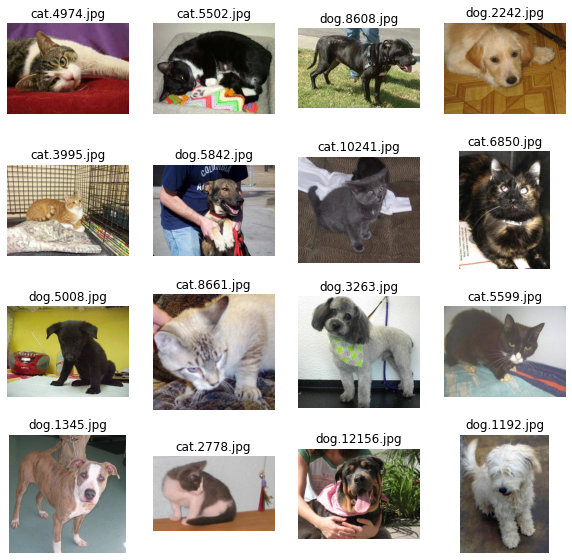

In [4]:
# train data가 어떻게 구성되어있는지 확인하자.

import cv2
import matplotlib.pyplot as plt

train_root = "./train"

fig = plt.figure(figsize=(10, 10))
for i, f in enumerate(train_files[:16], 1):
    file_path = os.path.join(train_root, f)
    img_bgr = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    ax = fig.add_subplot(4, 4, i)
    ax.set_title(f)
    ax.axis("off")
    
    plt.imshow(img_rgb)
    
plt.show()

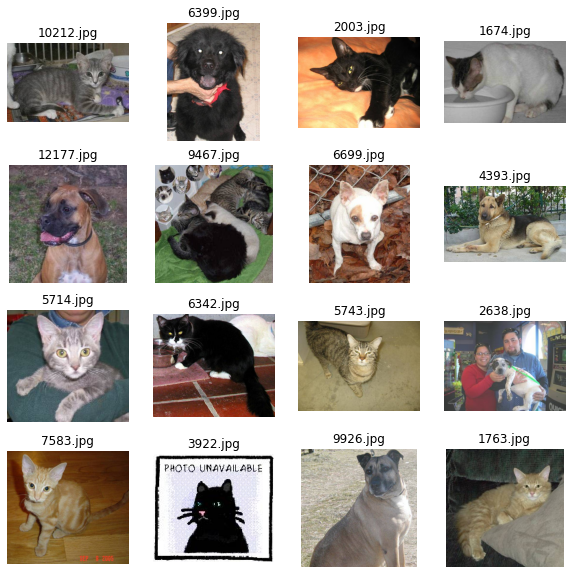

In [5]:
# test data가 어떻게 구성되어있는지 확인하자.

test_root = "./test1"

fig = plt.figure(figsize=(10, 10))
for i, f in enumerate(test_files[:16], 1):
    file_path = os.path.join(test_root, f)
    img_bgr = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    ax = fig.add_subplot(4, 4, i)
    ax.set_title(f)
    ax.axis("off")
    
    plt.imshow(img_rgb)

### 정리

#### 데이터 갯수
- train dataset : 25000장
- test datset : 12500장

#### train 데이터 형태
- 파일 경로에 class명(dog/cat)이 포함되어 있음

#### test 데이터 형태
- 파일마다 numbering이 되어있음

## 2. Custom Dataset class 정의

파이토치 튜토리얼에서 Custom Dataset class는 다음과 같다.

```python
class CustomImageDataset(Dataset):
    def __init__(self):
        ...
        
    def __len__(self):
        ...

    def __getitem__(self):
        ...
```

`__init__`
- image와 label의 경로와 transform 등을 설정합니다.

`__len__`
- 데이터셋의 샘플 개수를 반환합니다.

`__getitem__`
- 데이터셋에서 데이터를 불러옵니다.

In [6]:
# Custom Dataset 클래스를 정의하자
# 이미지 파일 경로, 레이블 정보, transform을 입력으로 받는다고 가정하자.

from torch.utils.data import Dataset, DataLoader
from PIL import Image

class DogCatDataset(Dataset):
    
    def __init__(self, data_dir, file_list, label_list=None, train=True, transform=None):
        self.data_dir = data_dir
        self.file_list = file_list
        self.transform = transform
        self.train = train
        if self.train:
            self.label_list = label_list
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.data_dir, self.file_list[idx]))        
        if self.transform:
            image = self.transform(image)
            
        if self.train:
            # image, label
            return image, self.label_list[idx]
        else:
            # image, test file number
            return image, self.file_list[idx][:-4]

## 3. Dataset 생성

In [7]:
# train file의 label을 만들자 (cat: 0, dog: 1)

train_files = sorted(os.listdir("./train"))
train_labels = [0 if "cat" in f else 1 for f in train_files]

print(len(train_files), len(train_labels))

25000 25000


In [8]:
# train set을 train과 validation set으로 나누자

from sklearn.model_selection import train_test_split

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, stratify=train_labels, random_state=42
)

# 잘 나누어졌는지 확인
print(len(train_files), len(train_labels), train_labels.count(0), train_labels.count(1))
print(len(val_files), len(val_labels), val_labels.count(0), val_labels.count(1))

18750 18750 9375 9375
6250 6250 3125 3125


In [9]:
# transform을 정의하자.
# 참고 링크: https://pytorch.org/vision/stable/transforms.html

import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(), # 0~1로 scaling
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # zero-centering
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # 0~1로 scaling
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # -1~1로 zero-centering
])

In [10]:
# 이제 train, valid dataset을 만들 수 있다.

train_dataset = DogCatDataset(data_dir="./train",
                              file_list=train_files,
                              label_list=train_labels,
                              train=True,
                              transform=train_transform)

val_dataset = DogCatDataset(data_dir="./train",
                            file_list=val_files,
                            label_list=val_labels,
                            train=True,
                            transform=eval_transform)

In [11]:
# 동일한 방식으로, test dataset도 만들어주자.

test_files = sorted(os.listdir("./test1"))
test_dataset = DogCatDataset(data_dir="./test1",
                             file_list=test_files,
                             train=False,
                             transform=eval_transform)

## 4. DataLoader 생성

In [12]:
# DataLoader를 만들어보자.

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1])


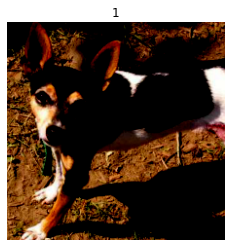

In [13]:
# train_loader가 잘 동작하는지 테스트해보자.

images, labels = next(iter(train_loader))
print(images.shape)
print(labels)

plt.imshow(images[0].permute(1, 2, 0))
plt.title(labels[0].item())
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])
tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0])


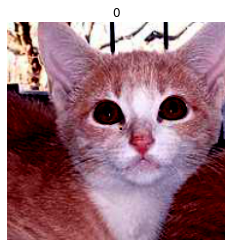

In [14]:
# val_loader가 잘 동작하는지 테스트해보자.

images, labels = next(iter(valid_loader))
print(images.shape)
print(labels)

plt.imshow(images[0].permute(1, 2, 0))
plt.title(labels[0].item())
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])
('1', '10', '100', '1000', '10000', '10001', '10002', '10003', '10004', '10005', '10006', '10007', '10008', '10009', '1001', '10010', '10011', '10012', '10013', '10014', '10015', '10016', '10017', '10018', '10019', '1002', '10020', '10021', '10022', '10023', '10024', '10025')


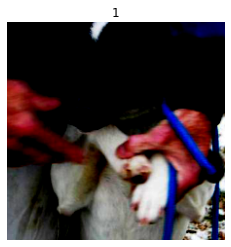

In [15]:
# test_loader가 잘 동작하는지 테스트해보자.

images, labels = next(iter(test_loader))
print(images.shape)
print(labels)

plt.imshow(images[0].permute(1, 2, 0))
plt.title(labels[0])
plt.axis("off")
plt.show()